# Participant Prediction

In [1]:
%precision 3
%matplotlib inline

## Load data

In [2]:
import data
import pandas as pd

In [3]:
def get_recurring_runners_from(curr_year, next_year):
    return df.loc[(df.year == next_year) & (df.years_since_run == next_year - curr_year)]


def set_participated_next_year(year):
    next_df = get_recurring_runners_from(year, year + 1)
    recurring_ids = next_df.id.unique()
    df.loc[(df.year == year) & (df.id.isin(recurring_ids)), "participated_next_year"] = True

In [4]:
raw_df = data.get_data()
df = pd.DataFrame()

df["id"] = raw_df["id"]
df["age"] = raw_df["age"].apply(lambda x: 5 * (x // 5))
df["male"] = raw_df["male"]
df["year"] = raw_df["year"]
df["run_count"] = raw_df["run_count"]
df["ran_a_lot"] = raw_df["run_count"].apply(lambda x: x > 7)
df["years_since_run"] = raw_df["years_since_run"]
df["ran_last_year"] = raw_df["years_since_run"].apply(lambda x: x == 1)
df["time_in_seconds"] = raw_df["time_in_seconds"]
df["ignore"] = raw_df["ignore"]
df["participated_next_year"] = False
for year in range(2003, 2016):
    set_participated_next_year(year)

df = df.loc[df.ignore == False]

In [5]:
df

,id,age,male,year,run_count,ran_a_lot,years_since_run,ran_last_year,time_in_seconds,ignore,participated_next_year
0,1,30,1,2016,0,False,-1,False,15300.0,False,False
1,2,60,1,2016,0,False,-1,False,18342.0,False,False
2,3,30,0,2016,0,False,-1,False,18274.0,False,False
3,4,35,1,2015,0,False,-1,False,13977.0,False,True
4,4,35,1,2016,1,False,1,True,18810.0,False,False
5,5,40,0,2016,8,True,2,False,19714.0,False,False
6,5,40,0,2014,7,False,2,False,20594.0,False,False
7,5,35,0,2010,4,False,1,True,19744.0,False,True
8,5,35,0,2008,2,False,1,True,19729.0,False,True
9,5,35,0,2009,3,False,1,True,19647.0,False,True


## Set up training data

In [6]:
import numpy as np

In [7]:
def get_nb_inputs(df):
    return df[["age", "male", "run_count", "ran_last_year"]]


def get_reg_inputs(df):
    return df[["age", "male", "run_count", "years_since_run",
               "time_in_seconds"]]


def get_outputs(df):
    return df["participated_next_year"]


def count(df):
    return df.count().id

In [8]:
TRAINING_DATA_PERCENT = 0.70

dataset = df[(df.year > 2010)]
training_mask = np.random.rand(len(dataset)) < TRAINING_DATA_PERCENT
training = dataset[training_mask]
testing = dataset[~training_mask]

training_nb_inputs = get_nb_inputs(training)
training_reg_inputs = get_reg_inputs(training)
training_outputs = get_outputs(training)

testing_nb_inputs = get_nb_inputs(testing)
testing_reg_inputs = get_reg_inputs(testing)
testing_outputs = get_outputs(testing)

In [9]:
training_positives = count(training[training.participated_next_year])
training_total = count(training)

testing_positives = count(testing[testing.participated_next_year])
testing_total = count(testing)

In [10]:
training_positives, training_total, training_positives / training_total

(1374, 14227, 0.097)

In [11]:
testing_positives, testing_total, testing_positives / testing_total

(531, 6100, 0.087)

## Classify

### Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB as NB

In [13]:
nb = NB()
nb = nb.fit(training_nb_inputs, training_outputs)

In [14]:
nb_predictions = nb.predict(testing_nb_inputs)

### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
reg = LogisticRegression()
reg = reg.fit(training_reg_inputs, training_outputs)

In [17]:
reg_predictions = reg.predict(testing_reg_inputs)

## Metrics

In [18]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [19]:
def get_confusion_matrix(predictions, truth):
    confusion = confusion_matrix(truth, predictions)
    confusion_df = pd.DataFrame(confusion,
                                index=["N", "Y"],
                                columns=["N", "Y"])
    percent_df = confusion_df.applymap(lambda x: x / confusion.sum())
    return confusion_df, percent_df


def plot_confusion_matrix(matrix):
    return sn.heatmap(matrix, annot=True)

### Naive Bayes

In [20]:
confusion_df, percent_df = get_confusion_matrix(nb_predictions, testing_outputs)

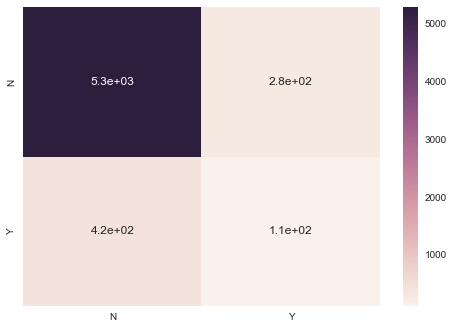

In [21]:
plot_confusion_matrix(confusion_df)

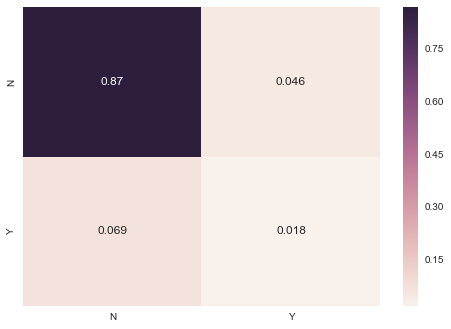

In [22]:
plot_confusion_matrix(percent_df)

In [23]:
nb.score(testing_nb_inputs, testing_outputs)

0.885

### Logistic Regression

In [24]:
confusion_df, percent_df = get_confusion_matrix(reg_predictions, testing_outputs)

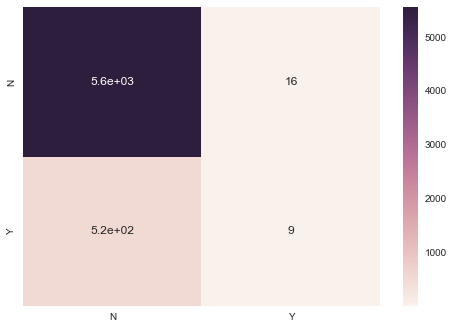

In [25]:
plot_confusion_matrix(confusion_df)

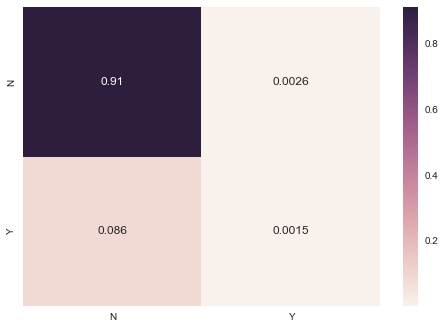

In [26]:
plot_confusion_matrix(percent_df)

In [27]:
reg.score(testing_reg_inputs, testing_outputs)

0.912